In [2]:
import numpy as np
import matplotlib.pyplot as plt

# INF 554 Lab 3: Supervised Classification

In this lab we will perform the task of binary classification, i.e., we will be working with a dataset, in which each datapoint belongs to one of two classes. There is data provided in the *data/* folder. Suppose that each column represents an exam score during a course, with the class label indicated *admitted* or not into a Masters program at some university. We want a model to give the probability that a student will be admitted based on the two grades of two courses.  We begin by loading and inspecting the data.

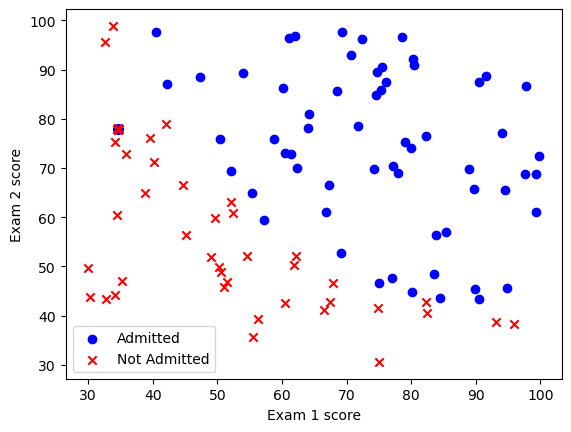

In [3]:
# Load the dataset
data = np.loadtxt('./data/data.csv', delimiter=',')
 
#Add intercept term 
data_1 = np.ones((data.shape[0], 4))
data_1[:, 1:] = data

X = data_1[:, 0:3]
y = data_1[:, -1]
y = y.reshape(-1, 1)


# Plot data 
pos = np.where(y == 1) # instances of class 1
neg = np.where(y == 0) # instances of class 0
plt.scatter(X[pos, 1], X[pos, 2], marker='o', c='b')
plt.scatter(X[neg, 1], X[neg, 2], marker='x', c='r')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Admitted', 'Not Admitted'])
plt.show()


N = X.shape[0]



## Logistic Regression and Gradient Descent


In linear regression, we got a real-valued response
	
$$y = \theta_0 + \theta_1 x_1 + \cdots + \theta_d x_d$$
    
i.e., a linear combination of inputs, where $y \in \mathbf{R}$.

<div class="alert alert-block alert-info">
Note: in this lab we are going to use $\mathbf{\theta}$ to denote the parameters, instead of $\mathbf{\beta}$ as we introduced in the first lab</div>

In classification, we want an *indication* of how likely an instance is to belong to a particular class; a probability $\in [0,1]$.  

Given a real valued $z$, we can squish it to range $\sigma(z) \in [0,1]$ by feeding it through the **logistic function** aka **sigmoid function**:
		
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)} \hspace{1.5cm}(1)
\end{equation}

Which looks like this: ![Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

Therefore, we can treat this as a probability, i.e.,

\begin{align*}
P(y=1|\mathbf{x}) &= \sigma(\mathbf{\theta}^\top\mathbf{x}) \\
P(y=0|\mathbf{x}) &= 1 - \sigma(\mathbf{\theta}^\top\mathbf{x}) 
\end{align*}

where we omit the bias term and suppose that both $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors.

> **Task 1**: implement the sigmoid function (1). Note that the sigmoid function in NumPy is prone to overflow errors therefore to avoid them you will have to use the <a href="https://numpy.org/doc/stable/reference/generated/numpy.clip.html">clip</a> function to restrain the input $z$ of the function within the interval $[-10 ,10]$.


In [4]:
def sigmoid(z):
    # insert here the code for Task 1
    return 1./(1.+np.exp(-np.clip(z, -10, 10)))

In order to chose values for the parameters of logistic regression, we use **maximum likelihood estimation** (MLE). As such we are going to have two steps:

1. write the likelihood function;
2. find the values of $\theta$ that maximize the log-likelihood function.


We begin by defining the design matrix $X=[x_1^T; \dots ; x_n^T]$ containing our data points $x_i^T \in \mathbb{R}^{1\times d}$ on its rows and our column vector of model paramters $\theta \in \mathbb{R}^{d\times 1}.$
The labels that we are predicting are binary, this means that we can interpret each label as a Bernoulli random variable: $Y \sim Ber(p)$ where $p = \sigma(\mathbf{\theta}^\top\mathbf{x})$.

Therefore, we can write the probability of a data point as:
$$
P\left(Y=y|X=\mathbf{x}\right) = \sigma(\mathbf{\theta}^\top\mathbf{x})^y \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x})\right]^{(1-y)}
$$

With the probability mass function we can now write the **likelihood** of the whole dataset:

\begin{equation}
L(\theta) = \prod_{i=1}^n P(Y = y_i|\mathbf{X} = \mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\theta}^\top\mathbf{x}_i)^{y_i} \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]^{(1-y_i)} \hspace{1.5cm}(2)
\end{equation}

We can take the log of this function to transform the product into a sum and by doing that, we obtain the **log-likelihood**:

\begin{equation}
LL(\theta) = \sum_{i=1}^n y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \hspace{1.5cm}(3)
\end{equation}

As you will remember from first lab, our objective is to minimize the error that we do by fitting our model to the data. However, log-likelihood increases when the model is fitting better to the data. That's the reason why in logistic regression we take the *negative* log-likelihood (also known as **cost** function $E(\theta)$).

> **Task 2**: implement the negative log likelihood, or cost function

In [5]:
def cost(theta, X, y):
    # Computes the cost using theta as the parameters for logistic regression.
    # insert here your implementation
    return - np.sum(y * np.log(sigmoid(X@theta)) + (1-y) * np.log(1-sigmoid(X@theta)))

As in OLS of the previous lab we want to find values of the parameters which minimize our cost function. 

>**Ques 1**:Derive the gradient of the cost function with respect to the model's parameters $\nabla_{\mathbf{\theta}} E(\mathbf{\theta})$.

<div class="alert alert-block alert-info">
Some hints:
    
- you can use the expression of a Bernoulli distribution, $\sigma_i^{y_i} (1-\sigma_i)^{1-y_i}$ where $\sigma_i \equiv \sigma(\mathbf{\theta}^\top\mathbf{x}_i)$. 

- A useful derivative: $\sigma' = (1 - \sigma)\sigma$.</div>

You'll notice that, unlike under OLS, it's not a closed form expression; you have $\mathbf{\theta}$ on the right hand side of the equation. Nevertheless, we can use numerical methods to find the optimal ${\mathbf{\theta}^*}$.

>**Task 3**: Implement the gradient of the cost function (which you just derived above).


In [6]:
def compute_grad(theta, X, y):
    # Computes the gradient of the cost with respect to the parameters.
    
    return X.T @ (sigmoid(X@theta)- y)

What we have now is a vector $\mathbf{g} = \nabla_{\mathbf{\theta}} E(\mathbf{\theta})$; the **gradient** of the cost function. Note that the dimensionality is the same as the input. We can move in the direction of the gradient and thus descend the function. This is the idea of **Gradient Descent**: we iteratively follow the gradient down the error surface. We repeatedly carry out 
\begin{equation}
\mathbf{\theta}_{t+1} = \mathbf{\theta}_{t} - \alpha \nabla_{\mathbf{\theta}} E(\mathbf{\theta}_t) \hspace{1.5cm}(4)
\end{equation}

where $\alpha$ is the **learning rate**; for $t=1,2,\ldots,T$, such that $\mathbf{\theta}^* \gets \mathbf{\theta}_T$.


Now all it's remaining to do is to find the optimal parameters using gradient descent. In the following we make a train-test split of the data provided, keeping the last 20 data points as test set away, and the first 80 as train. (*Note: If we apply the terminology that we introduced in the first lab, we actually carry out validation; but since we don't have a proper test set in this case, we can call the validation set "test set"*).



 
> **Task 4**: Please complete following sub-tasks. 
>1) Use the functions implemented so far to implement gradient descent, Eq.(4), for a fixed number of steps (say, $T=1\,000$) and three different learning rates: $\alpha \in \{0.5, 0.05, 0.005\}$.
>2) Evaluate the classifier (similarly to what was done in the first lab): plot the error $E(\mathbf{\theta}_t)$ both on the training and test set, for $t=1, 10, 20, 30, \ldots,T$ (make sure to divide both the error $E(\mathbf{\theta}_t)$ recorded on the training and test set by the number of data points they contain such that the two errors are on the same scale and can reasonably be compared). 


(3, 1)
(80, 3)
(80, 1)
(3, 1)
The fitted parameters for alpha=0.5 are:[[ 3.31448446]
 [10.7426847 ]
 [ 6.03332245]]
(3, 1)
(80, 3)
(80, 1)
(3, 1)
The fitted parameters for alpha=0.05 are:[[0.74356907]
 [4.10194629]
 [3.78930574]]
(3, 1)
(80, 3)
(80, 1)
(3, 1)
The fitted parameters for alpha=0.005 are:[[0.72220164]
 [3.98682008]
 [3.68459716]]


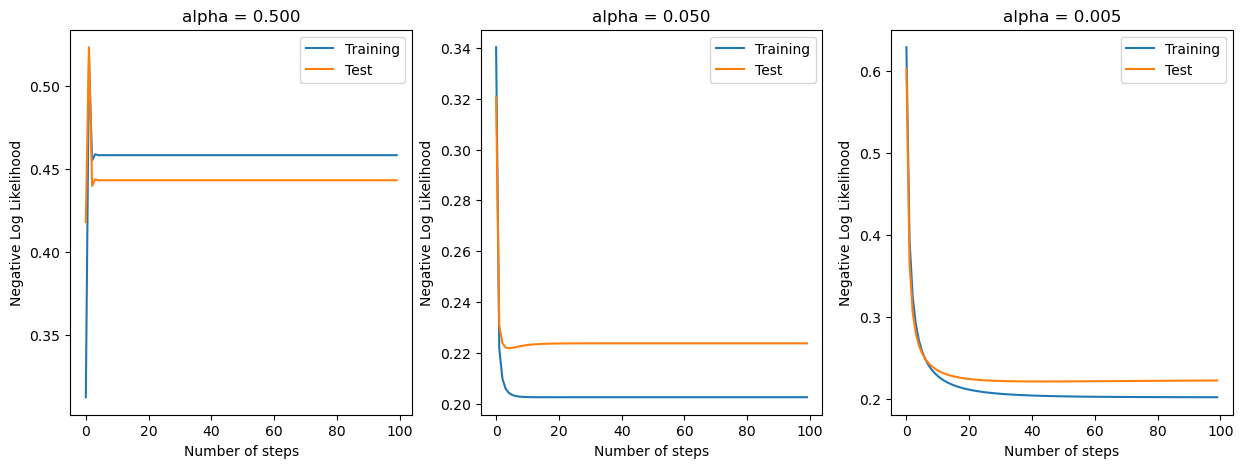

In [16]:
n_test=20

X_train = data_1[:-n_test, 0:3]
y_train = data_1[:-n_test, -1]
y_train = y_train.reshape(-1,1)

X_test = data_1[-n_test:, 0:3]
y_test = data_1[-n_test:, -1]
y_test = y_test.reshape(-1,1)

#standardize train and test (as in lab1 we use mean and st.dev from training to standardize test)
m = np.mean(X_train[:,1:3],axis=0)
s = np.std(X_train[:,1:3],axis=0)
X_train[:,1:3] = (X_train[:,1:3] - m) / s
X_test[:,1:3] = (X_test[:,1:3] - m) / s

T = 1000
fig, axs = plt.subplots(1,3, figsize=(15,5))  

alphas = [0.5, 0.05, 0.005]
thetas = []

for j in range(len(alphas)):
    training_likelihood = np.zeros(int(T/10))
    test_likelihood = np.zeros(int(T/10))
    
    alpha=alphas[j]
    theta = np.random.randn(3,1) * 0.05

    print(theta.shape)
    print(X_train.shape)
    print(y_train.shape)

    for i in range(T): 
        # insert here your code
        theta = theta - alpha * compute_grad(theta, X_train, y_train)

        if i%10==0:
            training_likelihood[int(i/10)] = cost(theta, X_train, y_train)/len(y_train)
            test_likelihood[int(i/10)] = cost(theta, X_test, y_test)/len(y_test)
    
    print(theta.shape)

    print(f'The fitted parameters for alpha={alpha} are:{theta}')
    thetas.append(theta)
 

    axs[j].plot(np.arange(int(T/10)), training_likelihood)
    axs[j].plot(np.arange(int(T/10)), test_likelihood)
    axs[j].legend(['Training', 'Test'])
    axs[j].set_title("alpha = %1.3f" % alpha)
    axs[j].set_ylabel('Negative Log Likelihood')
    axs[j].set_xlabel('Number of steps')

> **Ques 2**: Compare the log-likelihood graphs. What results can you draw regarding the learning rate and the performance of the model? Knowing that the cost function is convex, are you convinced that with a suitable learning rate, gradient descent will always converge to the minimum?

> **Task 5**: Implement a function to provide predictions $\hat{\mathbf{y}} \in \{0,1\}$ for any given $\mathbf{x}$ and $\hat{\mathbf{\theta}}$ (from the previous task) by assigning $\hat{\mathbf{y}}_i = 1$ whenever $\sigma_i \geq 0.5$. In other words, you turn logistic regression into a **classifier**. 

In [14]:
def predict(theta, X):
    #print(theta, "theta")
    # Predict whether each label is 0 or 1 using learned logistic regression parameters w. The threshold is set at 0.5
    # Insert here your code
    yp = 1*(sigmoid(X@theta)>=0.5)
    
    return yp    

#print(X_test.shape)
#print(y_test.shape)

#Let's take a look at the final accuracy
for theta in thetas:
    #print(predict(theta, X_test).T)
    #print(y_test.T)
    print(theta.shape)

    accuracy_train = 1 - np.mean(np.abs(predict(theta,X_train)-y_train))
    accuracy_test = 1 - np.mean(np.abs(predict(theta,X_test)-y_test))
    print("theta:\n", theta)
    print("Accuracy on training set:", accuracy_train)
    print("Accuracy on test set:", accuracy_test)

(3, 1)
theta:
 [[ 3.31448446]
 [10.7426847 ]
 [ 6.03332245]]
Accuracy on training set: 0.9125
Accuracy on test set: 0.85
(3, 1)
theta:
 [[0.74356907]
 [4.10194629]
 [3.78930574]]
Accuracy on training set: 0.8875
Accuracy on test set: 0.9
(3, 1)
theta:
 [[0.72217022]
 [3.98665233]
 [3.68444449]]
Accuracy on training set: 0.8875
Accuracy on test set: 0.9


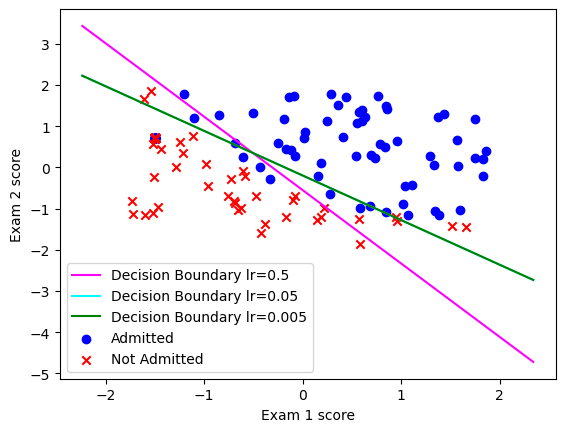

In [9]:
# Let's plot the learned decision boundary
#X = data_1[-n_test:, 0:3] #only test
#y = data_1[-n_test:, -1] #only test
#X = data_1[:-n_test, 0:3] #only train
#y = data_1[:-n_test, -1] #only train
#y = y.reshape(-1, 1)
#pos = np.where(y == 1) # instances of class 1
#neg = np.where(y == 0) # instances of class 0

# Plot data 
plt.figure()
plot_x = np.array([min(X[:, 1])-0.5, max(X[:, 2])+0.5])
cols=['magenta', 'cyan', 'green']
for i in range(len(thetas)):
    theta=thetas[i]
    plot_y = (- 1.0 / theta[2,0]) * (theta[1,0] * plot_x + theta[0,0])
    plt.plot(plot_x, plot_y, c=cols[i])
plt.scatter(X[pos, 1], X[pos, 2], marker='o', c='b')
plt.scatter(X[neg, 1], X[neg, 2], marker='x', c='r')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(['Decision Boundary lr=0.5', 'Decision Boundary lr=0.05','Decision Boundary lr=0.005','Admitted', 'Not Admitted'])
plt.show()

> **Ques 3**:  Compare qualitatively the decision boundaries obtained for the parameters learned with the three different learning rates

> **Task 6**: Instead of the whole training set, select a random subset (i.e., minibatch) of 10 examples for each iteration. This is known as **stochastic gradient descent**.

Our fitted parameters are:
 [[0.72811048]
 [4.12384481]
 [3.75979405]]


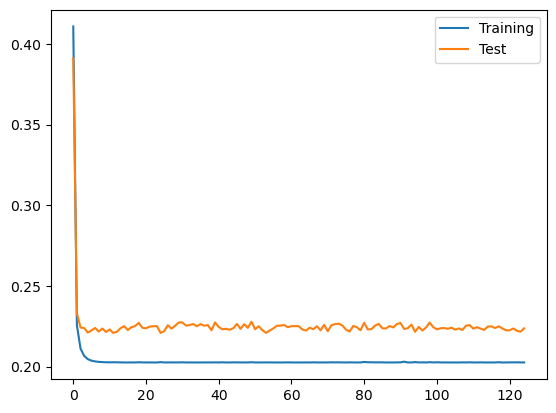

In [10]:
training_likelihood = []
test_likelihood = []

def sgd(n_iterations, batch_size, alpha, X, y):
    # insert your code here
    epochs = int(n_iterations/(len(y)/batch_size))
    
    theta = np.random.randn(3,1) * 0.05
    
    for i in range(epochs):
        idx = np.random.permutation(X.shape[0])
        for batch_index in range(int(X.shape[0]/batch_size)):
            current_batch = idx[batch_index*batch_size:(batch_index+1)*batch_size]
            theta = theta - alpha * compute_grad(theta, X[current_batch, :], y[current_batch])
    
        if i%10==0:
            training_likelihood.append(cost(theta, X_train, y_train)/len(y_train))
            test_likelihood.append(cost(theta, X_test, y_test)/len(y_test))
            
    return theta

            
alpha = 0.05
theta = sgd(10000, 10, alpha, X_train, y_train)
print('Our fitted parameters are:\n', theta)

plt.figure()
plt.plot(np.arange(125), training_likelihood)
plt.plot(np.arange(125), test_likelihood)
plt.legend(['Training', 'Test'])
plt.show()

> **Ques 4**: What are the advantages of stochastic gradient descent over classical gradient descent? (Especially with a non-convex loss function).

## K-Nearest Neighbours

The method $k$NN takes a different approach to modeling $P(Y=1|\mathbf{x})$. It is a *non-parametric* **lazy** method, and does not have a "model" as such. It predicts with
$$
P(Y=1|\mathbf{x}) \approx \frac{1}{k} \sum_{\mathbf{x}_i \in \textsf{Ne}_k(\mathbf{x})} y_i 
$$
where $\textsf{Ne}_k(\mathbf{x})$ is the *neighbourhood* of the $k$ training examples closest to $\mathbf{x}$ (typically measured by Euclidean distance). 

> **Ques 5**: What is the effect of different values of $k$? Hint: Draw on paper and/or empirically test different values.

> **Ques 6**: What is the complexity of making a prediction with a naive implementation of $k$-NN? When is this likely to be a problem in practice?

> **Task 7**: Implement this function to create a $k$-NN classifier and evaluate it on the data provided. Hint: there is not really any training stage here; simple store the training instances to search over later.

In [11]:
from numpy.linalg import norm

def kNN(k, X, y, x):
    '''
    kNN classification of x
    -----------------------
        Input: 
        k: number of nearest neighbors
        X: training data           
        y: class labels of training data
        x: test instance

        return the label to be associated with x

        Hint: you may use the function 'norm' 
    '''
    # Enter here your solution for Task 9
    
    
    distances = norm(X-x, axis=1)
    
    idx = distances.argsort()
    
    labels = y[idx]
    
    classes, counts = np.unique(labels[:k], return_counts=True)
    
    classification = np.argmax(counts)
    
    return classes[classification]
    
    

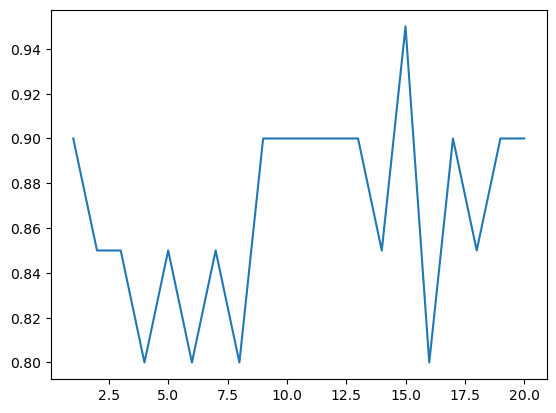

In [12]:
# Test the kNN method for various k
Kmax=20
knn_accuracy = np.zeros(Kmax)
for k in range(1, Kmax+1):
    y_pred = np.zeros(len(y_test))
    

    for i in range(len(y_pred)):
        y_pred[i] = kNN(k, X_train, y, X_test[i,:])
        
            
        

    knn_accuracy[k-1] = 1-np.mean(np.abs(y_pred.reshape(-1,1)-y_test))
        

plt.plot(np.arange(1,Kmax+1), knn_accuracy)
plt.show()